<a href="https://colab.research.google.com/github/ramonfv/iniciacao-cientifica-BCI/blob/main/Script_artigo_Eletiva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Autores:

Leonardo Castro Souza Marotta

Rafael Fernandes Almeida

Ramon Fernandes Viana

Script desenvolvido para elaboração de artigo da disciplina Tópicos Especiais em TELECOM III

---



Este script faz parte da implementação das etapas de construção de uma BCI (Brain Computer Interface).

Este trabalho contém as seguintes partes: Entrada de dados, Pré-Processamento, Estração de Características, Seleção de Características e Classificação



A base de dados utilizada neste trabalho pode ser acessada pelo link:
http://bci.med.tsinghua.edu.cn/download.html

In [ ]:
#Bibliotecas científicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sp
import scipy.io as sio
from scipy import signal
from scipy.fft import fft
import math 
from numpy import array
from scipy.io import loadmat
import matplotlib.patches as mpatches
from bisect import bisect_left

#Biblioteca de aprendizado de máquina
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Sequential
from keras.layers.core import Dense
from sklearn.cross_decomposition import CCA
from tensorflow.keras.optimizers import *

In [ ]:
# Aleatóriamente o indivíduo 34 foi escolhido
mat = sio.loadmat('/content/S34.mat', verify_compressed_data_integrity=False)            
data = np.array(mat['data'])
data.shape


(64, 1500, 40, 6)

In [ ]:
# Parâmetros de entrada
# conforme definido no artigo, o sinal coletado tem duração de 6s no entanto os 0,5s iniciais e finais são desconsiderados
int_dados = data[:,125:1375];
sinal_10Hz = data[:,125:1375,2,:];
sinal_12Hz = data[:,125:1375,4,:];
sinal_15Hz = data[:,125:1375,7,:];
sinal_10Hz.shape
# aqui, temos a entrada normalizada com o tempo. nesse momento todas as trials e frequencias serao consideradas
rows,cols,freqs,trials = int_dados.shape
filter_10Hz = [[0 for i in range(cols)] for j in range(rows)];
filter_12Hz = [[0 for i in range(cols)] for j in range(rows)];
filter_15Hz = [[0 for i in range(cols)] for j in range(rows)];


In [ ]:
# Frequência de Amostragem
Fs = 250;
res_esp = Fs/1250;
freq = np.arange(1250)*(res_esp);
# vetor de tempo
time = np.arange(1250)*1/Fs; 

Etapa de Pré-Processamento - Filtro CAR

In [ ]:
# filtro CAR para o sinal de 10Hz
def CAR10(sinal_10Hz):
    V_aux = np.array(sinal_10Hz);
    for j in range(cols):
      for i in range(rows):
          mean = np.mean(V_aux[:,j]);
          filter_10Hz[i][j] = V_aux[i,j] - mean;
    return filter_10Hz;     

In [ ]:
# filtro CAR para o sinal de 12Hz
def CAR12(sinal_12Hz):
    V_aux = np.array(sinal_12Hz);
    for j in range(cols):
      for i in range(rows):
          mean = np.mean(V_aux[:,j]);
          filter_12Hz[i][j] = V_aux[i,j] - mean;
    return filter_12Hz;  

In [ ]:
# filtro CAR para o sinal de 15Hz
def CAR15(sinal_15Hz):
    V_aux = np.array(sinal_15Hz);
    for j in range(cols):
      for i in range(rows):
          mean = np.mean(V_aux[:,j]);
          filter_15Hz[i][j] = V_aux[i,j] - mean;
    return filter_15Hz;  

Sinais Filtrados - Filtragem CAR

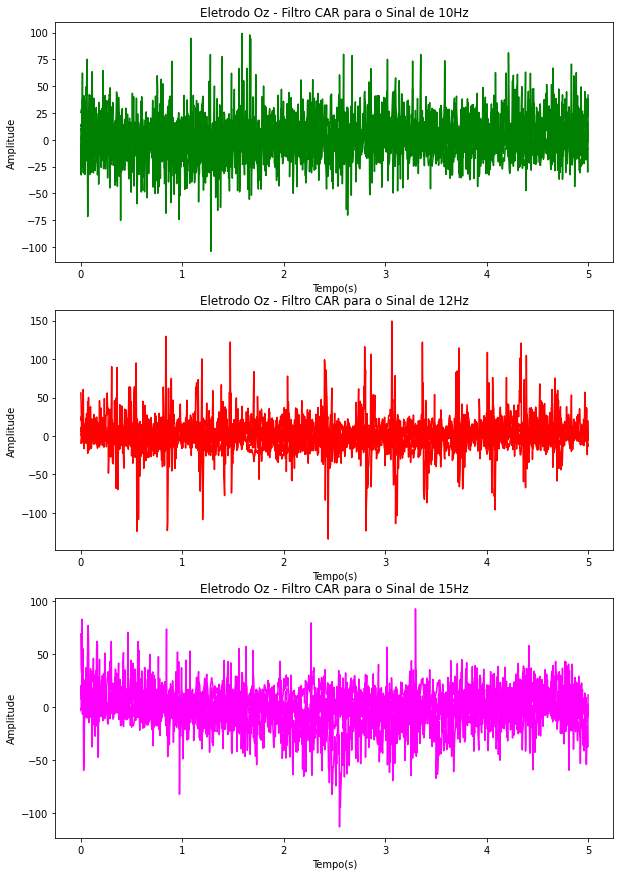

In [ ]:
# sinal filtrado 10Hz
Filter_CAR10 = np.array(CAR10(sinal_10Hz));
# sinal filtrado 12Hz
Filter_CAR12 = np.array(CAR12(sinal_12Hz));
# sinal filtrado 15Hz
Filter_CAR15 = np.array(CAR12(sinal_15Hz));
plt.figure(figsize=(10,15));
plt.subplot(3,1,1);
plt.plot(time,Filter_CAR10[61][:],color='green');
plt.title('Eletrodo Oz - Filtro CAR para o Sinal de 10Hz');
plt.xlabel('Tempo(s)')
plt.ylabel('Amplitude')
plt.subplot(3,1,2);
plt.plot(time,Filter_CAR12[61][:],color='red');
plt.title('Eletrodo Oz - Filtro CAR para o Sinal de 12Hz');
plt.xlabel('Tempo(s)')
plt.ylabel('Amplitude')
plt.subplot(3,1,3);
plt.plot(time,Filter_CAR15[61][:],color='magenta');
plt.title('Eletrodo Oz - Filtro CAR para o Sinal de 15Hz');
plt.xlabel('Tempo(s)')
plt.ylabel('Amplitude')
plt.show()

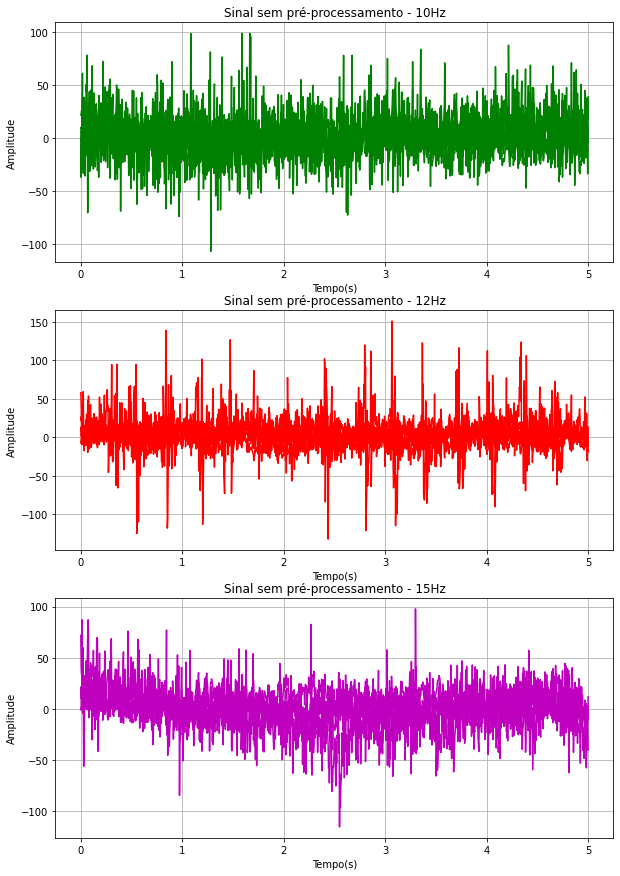

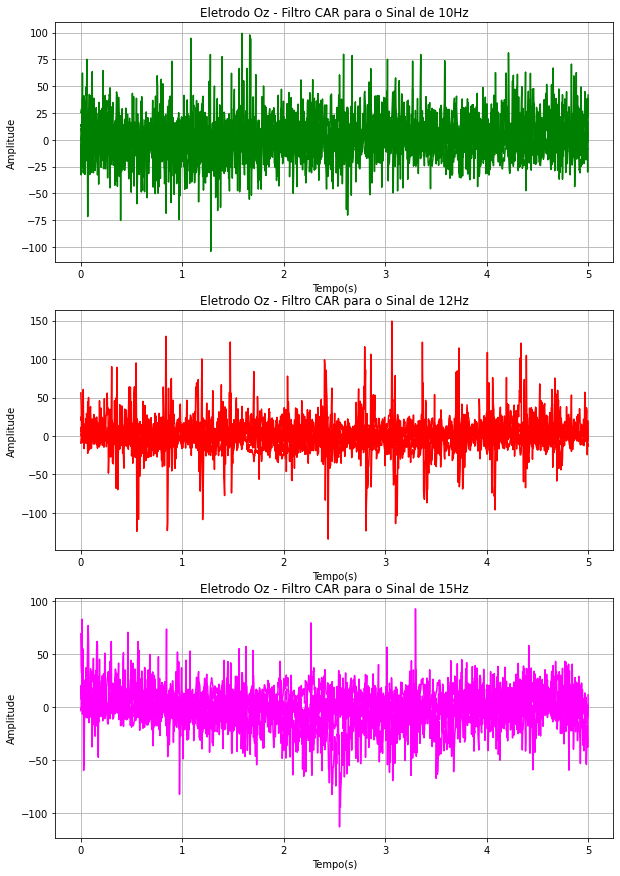

In [ ]:
from plotly import tools
from plotly.graph_objs import Layout, YAxis, Scatter, Annotation, Annotations, Data, Figure, Marker, Font
# plot dos sinais sem pré-processamento
plt.figure(figsize=(10,15))
plt.subplot(3,1,1)
plt.plot(time,sinal_10Hz[61,:],color='green');
plt.title('Sinal sem pré-processamento - 10Hz');
plt.xlabel('Tempo(s)')
plt.ylabel('Amplitude')
plt.grid()
plt.subplot(3,1,2)
plt.plot(time,sinal_12Hz[61,:],color='r');
plt.title('Sinal sem pré-processamento - 12Hz')#color ='r');
plt.xlabel('Tempo(s)')
plt.ylabel('Amplitude')
plt.grid()
plt.subplot(3,1,3)
plt.plot(time,sinal_15Hz[61,:],color='m');
plt.title('Sinal sem pré-processamento - 15Hz')#color ='r');
plt.xlabel('Tempo(s)')
plt.ylabel('Amplitude')
plt.grid()

# plot Sinal Filtrado - CAR
plt.figure(figsize=(10,15));
plt.subplot(3,1,1);
plt.plot(time,Filter_CAR10[61][:],color='green');
plt.title('Eletrodo Oz - Filtro CAR para o Sinal de 10Hz');
plt.xlabel('Tempo(s)')
plt.ylabel('Amplitude')
plt.grid()
plt.subplot(3,1,2);
plt.plot(time,Filter_CAR12[61][:],color='red');
plt.title('Eletrodo Oz - Filtro CAR para o Sinal de 12Hz');
plt.xlabel('Tempo(s)')
plt.ylabel('Amplitude')
plt.grid()
plt.subplot(3,1,3);
plt.plot(time,Filter_CAR15[61][:],color='magenta');
plt.title('Eletrodo Oz - Filtro CAR para o Sinal de 15Hz');
plt.xlabel('Tempo(s)')
plt.ylabel('Amplitude')
plt.grid()
plt.show()



Concatenação dos sinais filtrados - A filtragem selecionada para o trabalho foi a CAR


Outros testes foram executados com resultados até melhores do que o CAR, no entanto, o desempenho final da BCI se mostrou melhor para o CAR. Por esse motivo, as demais filtragens foram retiradas.

In [ ]:
dados = np.vstack((Filter_CAR10,Filter_CAR12,Filter_CAR15));
dados.shape


(192, 1250, 6)

Extração de Caracterísitcas - Análise com a FFT

In [ ]:
# matriz H - Extração com Método da FFT
VH_FFT = np.array([]);
#Bins de frequências desejadas
Vbin_f1 = np.where(freq == 10);
Vbin_f1 = np.asarray([[Vbin_f1]])
Vbin_f1 = Vbin_f1.item()
Vbin_f2 = np.where(freq == 12);
Vbin_f2 = np.asarray([[Vbin_f2]])
Vbin_f2 = Vbin_f2.item()
Vbin_f3 = np.where(freq == 15);
Vbin_f3 = np.asarray([[Vbin_f3]])
Vbin_f3 = Vbin_f3.item()

for freqs in range (3):
  VJ_FFT = np.array([]);
  for trial in range(trials):
    VT_FFT = np.array([]);
    for jan in range (5):
        VC_FFT = np.array([])
        for canal in range (rows):
          Vb = jan*250;
          Vc = (jan+1)*250;
          Vd = np.arange(Vb,Vc);
          VFFT =  np.abs(fft(dados[canal,Vd,trial]));
          Ve = VFFT[Vbin_f1];
          Vf = VFFT[Vbin_f2];
          Vg = VFFT[Vbin_f3];
          VA_FFT = np.array([[Ve,Vf,Vg]]); 
          if canal == 0:
              VC_FFT = np.array(VA_FFT);
          else:  
              VC_FFT= np.array(np.hstack((VC_FFT,VA_FFT)));
        if jan ==0 :    
          VT_FFT = np.array(VC_FFT);
        else:   
          VT_FFT = np.array(np.vstack((VT_FFT,VC_FFT)));

    if trial ==0:
      VJ_FFT = np.array(VT_FFT);
    else:
      VJ_FFT = np.array(np.vstack((VJ_FFT,VT_FFT))) 

  if freqs == 0:
        VH_FFT = np.array(VJ_FFT);
  else:
        VH_FFT = np.array(np.vstack((VH_FFT,VJ_FFT)));    

          
          

In [ ]:
VH_FFT.shape

(90, 192)

In [ ]:
#extração de Atributos com FFT

H_FFT = np.array([]);
bin_f1 = np.where(freq == 10);
bin_f1 = np.asarray([[bin_f1]])
bin_f1 = bin_f1.item()
bin_f2 = np.where(freq == 12);
bin_f2 = np.asarray([[bin_f2]])
bin_f2 = bin_f2.item()
bin_f3 = np.where(freq == 15);
bin_f3 = np.asarray([[bin_f3]])
bin_f3 = bin_f3.item()

canais = len(sinal_10Hz);

for ii in range(canais):

  FFT_10Hz = np.abs(fft(sinal_10Hz[ii,:,3])/len(sinal_10Hz));
  FFT_12Hz = np.abs(fft(sinal_12Hz[ii,:,3])/len(sinal_12Hz));
  FFT_15Hz = np.abs(fft(sinal_15Hz[ii,:,3])/len(sinal_15Hz));
  a = FFT_10Hz[bin_f1];
  b = FFT_10Hz[bin_f2];
  c = FFT_10Hz[bin_f3];
  d = FFT_12Hz[bin_f1];
  e = FFT_12Hz[bin_f2];
  f = FFT_12Hz[bin_f3];
  g = FFT_15Hz[bin_f1];
  h = FFT_15Hz[bin_f2];
  i = FFT_15Hz[bin_f3];
  A_FFT = np.array([[a,b,c],[d,e,f],[g,h,i]]);
  if ii == 0:
      H_FFT = A_FFT
  else: 
    H_FFT= np.concatenate([H_FFT,A_FFT])

H_FFT = np.transpose(H_FFT)    


Plot das frequência extraídas com FFT - Canais O1 e Oz

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning:

In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning:

In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning:

In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warnin

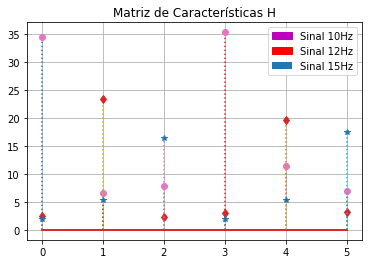

In [ ]:

plt.stem(H_FFT[0,180:186],linefmt = ':', markerfmt='o');
eletrodo_oz1 = mpatches.Patch(color='m',label='Sinal 10Hz')
plt.legend(handles=[eletrodo_oz1])
plt.stem(H_FFT[1,180:186],linefmt = ':', markerfmt='d');
eletrodo_oz2 = mpatches.Patch(color='r',label='Sinal 12Hz')
plt.legend(handles=[eletrodo_oz2])
plt.stem(H_FFT[2,180:186],linefmt = ':', markerfmt='*');
eletrodo_oz3 = mpatches.Patch(label='Sinal 15Hz')
plt.title('Matriz de Características H - Método FFT');
plt.legend(handles=[eletrodo_oz1,eletrodo_oz2,eletrodo_oz3])
plt.grid()
plt.show()

In [ ]:
# SELECOA DE ATRIBUTOS COM PEARSON
#*************************************************
A = np.array(VH_FFT);  #matriz de características


Vet_1 = np.array(np.vstack((np.ones((30,64)),-np.ones((30,64)),np.ones((30,64)))));
Vet_2 = np.array(np.vstack((-np.ones((30,64)),np.ones((30,64)),-np.ones((30,64)))));
Vet_3 = np.array(np.vstack((np.ones((30,64)),-np.ones((30,64)),np.ones((30,64)))));
B = np.array(np.hstack((Vet_1,Vet_2,Vet_3)));
B.shape

(90, 192)

Definindo os rótulos

In [ ]:
  uns = np.ones((90,1));
# matriz atributos
H = np.array(np.hstack((A,uns)));
print(H.shape)
# matriz rótulos
R1 = np.ones((30,1));
R2 = -np.ones((30,1));
Rt1 = np.vstack((R1,R2,R2))
Rt2 = np.vstack((R2,R1,R2))
Rt3 = np.vstack((R2,R2,R1))
R = np.hstack((Rt1,Rt2,Rt3))
print(R.shape)
print(H.shape)


(90, 193)
(90, 3)
(90, 193)


Calculos dos eletrodos mais significativos para as frequências desejadas

In [ ]:
Vetor_R =  np.zeros((A.shape[1],B.shape[1]))

for freq in range (B.shape[1]):
  for ch in range (A.shape[1]):
    print(freq,ch)
    print(A[:,ch], B[:,freq])
    R = np.corrcoef(A[:,ch],B[:,freq])
    Vetor_R[ch,freq] = np.abs(R[1,0])

print(Vetor_R.shape)
indices_canais = np.argsort(Vetor_R, axis=0)[::-1]
print(indices_canais.shape)

A saída de streaming foi truncada nas últimas 5000 linhas.
  22.423539     7.86330068  15.16268211  22.96315715  27.63543925
  24.11710885  24.12387132  38.71886924  23.89176194  32.44363333
 125.46732386  57.08318841  62.69073584  18.73148297  67.66116031
 281.12164871 184.37612296  96.3492648  139.2250026   69.64983394
  12.36022857  36.22434957  10.03335142   4.72371535   6.86703059
  23.304803    18.93286568  33.2355225    9.95279147  16.17206127
  22.423539     7.86330068  15.16268211  22.96315715  27.63543925] [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
190 160
[ 79.60439097 100.49265668  39.86776612  81.12763964 156.03785373
 128.44059147  88.09912537 165.1038722

In [ ]:
print(indices_canais)
print(VH_FFT.shape)

[[ 51  51  51 ...  51  51  51]
 [ 53  53  53 ...  53  53  53]
 [153 153 153 ... 153 153 153]
 ...
 [ 90  90  90 ...  90  90  90]
 [159 159 159 ... 159 159 159]
 [ 28  28  28 ...  28  28  28]]
(90, 192)


In [ ]:
R1 = np.ones((30,1));
R2 = -np.ones((30,1));
Rt1 = np.vstack((R1,R2,R2))
Rt2 = np.vstack((R2,R1,R2))
Rt3 = np.vstack((R2,R2,R1))
R = np.hstack((Rt1,Rt2,Rt3))
print(R.shape)
print(H.shape)

(90, 3)
(90, 193)


Extração de Caracterísitcas - Análise com a welch

In [ ]:
X1 = np.array(Filter_CAR10[61,125:1375,3])
X2 = np.array(Filter_CAR12[61,125:1375,3])
X3 = np.array(Filter_CAR15[61,125:1375,3])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning:

In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning:

In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning:

In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this war

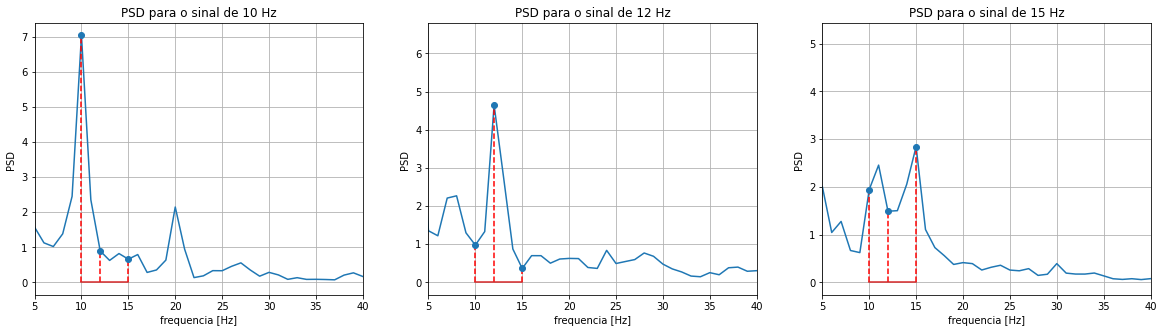

In [ ]:
T = 1
fs = 250
f10, Pxx_den10 = signal.welch(X1, fs, nperseg=T*fs, noverlap= T*fs/2)
f12, Pxx_den12 = signal.welch(X2, fs, nperseg=T*fs, noverlap= T*fs/2)
f15, Pxx_den15 = signal.welch(X3, fs, nperseg=T*fs, noverlap= T*fs/2)

#frequencia de 10 Hz
plt.figure(figsize=(20,5));
plt.subplot(1,3,1);
plt.plot(f10, Pxx_den10)
ff= ([10,12,15])
P1= ([Pxx_den10[10], Pxx_den10[12], Pxx_den10[15]])
P2= ([Pxx_den12[10], Pxx_den12[12], Pxx_den12[15]])
P3= ([Pxx_den15[10], Pxx_den15[12], Pxx_den15[15]])

plt.stem(ff,P1, 'r--')
#plt.ylim([0, 10])
plt.xlim(5, 40)
plt.title('PSD para o sinal de 10 Hz');
plt.xlabel('frequencia [Hz]')
plt.ylabel('PSD ')
plt.grid()

#frequeência de 12 Hz
plt.subplot(1,3,2);
plt.plot(f12, Pxx_den12)
plt.stem(ff,P2, 'r--')
#plt.ylim([0, 10])
plt.xlim(5, 40)
plt.title('PSD para o sinal de 12 Hz');
plt.xlabel('frequencia [Hz]')
plt.ylabel('PSD ')
plt.grid()

# frequencia de 15 Hz
plt.subplot(1,3,3);
plt.plot(f15, Pxx_den15)
plt.stem(ff,P3, 'r--')
#plt.ylim([0, 10])
plt.xlim(5, 40)
plt.title('PSD para o sinal de 15 Hz');
plt.xlabel('frequencia [Hz]')
plt.ylabel('PSD ')
plt.grid()
plt.show()

In [ ]:
F10, Pxx_den12 = signal.welch(Filter_CAR12, Fs, window='hanning', nperseg=256, detrend='constant',return_onesided=True,scaling='density', axis=-1);

/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning:

nperseg = 256 is greater than input length  = 6, using nperseg = 6



In [ ]:
H_Welch = [[0 for i in range(3)] for j in range(3)]
bin_f10 = np.where(f10 == 10);
bin_f12 = np.where(f12 == 12);
bin_f15 = np.where(f15 == 15);

T = 1
fs = 250
f10, Pxx_den10 = signal.welch(X1, fs, nperseg=T*fs, noverlap= T*fs/2)
for canal in range (rows):
  f_10, Pxx_10 = signal.welch(Filter_CAR10[canal,125:1375,3], fs, nperseg=T*fs, noverlap= T*fs/2)
  f_12, Pxx_12 = signal.welch(Filter_CAR12[canal,125:1375,3], fs, nperseg=T*fs, noverlap= T*fs/2)
  f_15, Pxx_15 = signal.welch(Filter_CAR15[canal,125:1375,3], fs, nperseg=T*fs, noverlap= T*fs/2)
  P10= ([Pxx_10[10], Pxx_10[12], Pxx_10[15]])
  P12= ([Pxx_12[10], Pxx_12[12], Pxx_12[15]])
  P15= ([Pxx_15[10], Pxx_15[12], Pxx_15[15]])
  A_Welch = np.vstack((P10,P12,P15))
  H_Welch = np.hstack((H_Welch,A_Welch))


In [ ]:
H_Welch.shape

(3, 195)

 EXTRACAO DE ATRIBUTOS COM WELCH

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning:

In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning:

In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning:

In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warnin

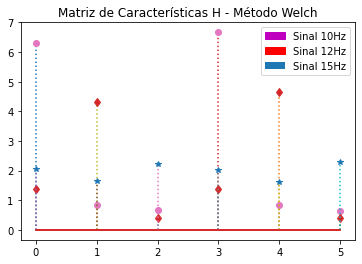

In [ ]:
plt.stem(H_Welch[0,180:186],linefmt = ':', markerfmt='o');
eletrodo_oz1 = mpatches.Patch(color='m',label='Sinal 10Hz')
plt.legend(handles=[eletrodo_oz1])
plt.stem(H_Welch[1,180:186],linefmt = ':', markerfmt='d');
eletrodo_oz2 = mpatches.Patch(color='r',label='Sinal 12Hz')
plt.legend(handles=[eletrodo_oz2])
plt.stem(H_Welch[2,180:186],linefmt = ':', markerfmt='*');
eletrodo_oz3 = mpatches.Patch(label='Sinal 15Hz')
plt.title('Matriz de Características H - Método Welch');
plt.legend(handles=[eletrodo_oz1,eletrodo_oz2,eletrodo_oz3])
plt.show()

In [ ]:
dados.shape

(192, 1250, 6)

Seleção de Caracterisiticas com Welch

In [ ]:
HN_Welch = np.array([])

for freqs in range (3):
  J_Welch = np.array([]);
  for trial in range(trials):
    T_Welch = np.array([]);
    for jan in range (5):
        C_Welch = np.array([])
        for canal in range (rows):
          b = jan*250;
          c = (jan+1)*250;
          d = np.arange(b,c);
          f_W, Pxx_W = signal.welch(dados[canal,d,trial], fs, nperseg=T*fs, noverlap= T*fs/2)
          PD10 = Pxx_W[10]
          PD12 = Pxx_W[12];
          PD15 = Pxx_W[15];
          A_WWelch = np.array([PD10,PD12,PD15])
          if canal == 0:
              C_Welch = np.array(A_WWelch);
          else:  
              C_Welch= np.array(np.hstack((C_Welch,A_WWelch)));
        if jan ==0 :    
          T_Welch = np.array(C_Welch);
        else:   
          T_Welch = np.array(np.vstack((T_Welch,C_Welch)));

    if trial ==0:
      J_Welch = np.array(T_Welch);
    else:
      J_Welch = np.array(np.vstack((J_Welch,T_Welch))) 

  if freqs == 0:
        HN_Welch = np.array(J_Welch);
  else:
        HN_Welch = np.array(np.vstack((HN_Welch,J_Welch)));    

          
          

In [ ]:
HN_Welch.shape

(90, 192)

Classificação

In [ ]:
print(indices_canais)

[[ 51  51  51 ...  51  51  51]
 [ 53  53  53 ...  53  53  53]
 [153 153 153 ... 153 153 153]
 ...
 [ 90  90  90 ...  90  90  90]
 [159 159 159 ... 159 159 159]
 [ 28  28  28 ...  28  28  28]]


In [ ]:
uns2 = np.ones((90,1));
# matriz atributos
H = np.array(np.hstack((A,uns)));
H.shape

In [ ]:
R1 = np.ones((30,1));
R2 = -np.ones((30,1));
Rt1 = np.vstack((R1,R2,R2))
Rt2 = np.vstack((R2,R1,R2))
Rt3 = np.vstack((R2,R2,R1))
R = np.hstack((Rt1,Rt2,Rt3))
print(R.shape)
print(H.shape)


(90, 3)
(90, 193)


SVM para todos os eletrodos


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import svm
#Considerando as matrizes com os dados em H e a matriz de rótulos R - equivalente ao código inicial do Matlab
#Particionar os dados usando 20% para validacao
Ht, Hv, Rt, Rv = train_test_split(H, R, test_size = 0.20)
#SVM - treinando
modelo1 = svm.SVC(kernel='linear').fit(Ht, Rt[:,0])
modelo2 = svm.SVC(kernel='linear').fit(Ht, Rt[:,1])
modelo3 = svm.SVC(kernel='linear').fit(Ht, Rt[:,2])
#SVM - validando
Y1 = modelo1.predict(Hv)
Y2 = modelo2.predict(Hv)
Y3 = modelo3.predict(Hv)
Y = np.vstack((Y1,Y2,Y3))
index = np.argmax(Y, axis=0)
index2 = np.argmax(Rv, axis=1)
#print(Y)
print(index)
print(index2)
# contando os acertos
corretos = 0

for i in range(len(Rv)):
    #if((Y[i,:]==Rv[i,:])):
    if(index[i] == index2[i]):
      corretos = corretos + 1

val_acc = (corretos/len(Rv))*100

print(Rv)
print('Label Real: ', Rt)
print('Label Predito: ', Y)
print('Acurácia da validação:', val_acc)
print(corretos)

[0 0 0 0 0 2 0 0 1 0 2 0 0 0 0 1 0 2]
[2 2 1 1 0 1 1 0 2 2 1 1 2 2 1 0 2 0]
[[-1. -1.  1.]
 [-1. -1.  1.]
 [-1.  1. -1.]
 [-1.  1. -1.]
 [ 1. -1. -1.]
 [-1.  1. -1.]
 [-1.  1. -1.]
 [ 1. -1. -1.]
 [-1. -1.  1.]
 [-1. -1.  1.]
 [-1.  1. -1.]
 [-1.  1. -1.]
 [-1. -1.  1.]
 [-1. -1.  1.]
 [-1.  1. -1.]
 [ 1. -1. -1.]
 [-1. -1.  1.]
 [ 1. -1. -1.]]
Label Real:  [[-1.  1. -1.]
 [ 1. -1. -1.]
 [-1.  1. -1.]
 [-1. -1.  1.]
 [-1. -1.  1.]
 [-1.  1. -1.]
 [-1. -1.  1.]
 [ 1. -1. -1.]
 [-1. -1.  1.]
 [-1.  1. -1.]
 [-1.  1. -1.]
 [ 1. -1. -1.]
 [-1.  1. -1.]
 [-1.  1. -1.]
 [-1.  1. -1.]
 [-1. -1.  1.]
 [-1.  1. -1.]
 [ 1. -1. -1.]
 [-1. -1.  1.]
 [-1.  1. -1.]
 [ 1. -1. -1.]
 [-1. -1.  1.]
 [ 1. -1. -1.]
 [-1. -1.  1.]
 [-1.  1. -1.]
 [-1.  1. -1.]
 [ 1. -1. -1.]
 [ 1. -1. -1.]
 [-1. -1.  1.]
 [-1. -1.  1.]
 [ 1. -1. -1.]
 [-1. -1.  1.]
 [-1.  1. -1.]
 [-1. -1.  1.]
 [-1.  1. -1.]
 [ 1. -1. -1.]
 [-1.  1. -1.]
 [ 1. -1. -1.]
 [-1.  1. -1.]
 [-1. -1.  1.]
 [ 1. -1. -1.]
 [ 1. -1. -1.]
 [-1. -1. 

In [ ]:
print(indices_canais[0:9,1])

[ 51  53 153 189  18 175  63  13 168]


In [ ]:
# Selecionando os melhores eletrodos
H_primeiro = VH_FFT[:,49:52]
H_primeiro.shape
H_segundo = VH_FFT[:,52:55]
H_terceiro = VH_FFT[:,151:154]
H_quarto = VH_FFT[:,16:19]
H_quinto = VH_FFT[:,175:178]
H_sexto = VH_FFT[:,61:64]
H_setimo = VH_FFT[:,13:16]
H_oitavo = VH_FFT[:,166:169]
H_novo = VH_FFT[:,127:130]
H_eletrodos = np.hstack((H_primeiro,H_segundo,H_terceiro,uns))
H_eletrodos.shape

(90, 10)

In [ ]:
H_segundo = VH_FFT[:,52:55]
H_segundo.shape

(90, 3)

SVM para os eletrodo mais correlacionados

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import svm
#Considerando as matrizes com os dados em H e a matriz de rótulos R - equivalente ao código inicial do Matlab
#Particionar os dados usando 20% para validacao
Ht1, Hv1, Rt1, Rv1 = train_test_split(H_eletrodos, R, test_size = 0.20)
#SVM - treinando
modelo1 = svm.SVC(kernel='linear').fit(Ht1, Rt1[:,0])
modelo2 = svm.SVC(kernel='linear').fit(Ht1, Rt1[:,1])
modelo3 = svm.SVC(kernel='linear').fit(Ht1, Rt1[:,2])
#SVM - validando
Y11 = modelo1.predict(Hv1)
Y22 = modelo2.predict(Hv1)
Y33 = modelo3.predict(Hv1)
Y_1 = np.vstack((Y11,Y22,Y33))
index = np.argmax(Y_1, axis=0)
index2 = np.argmax(Rv1, axis=1)
print(index)
print(index2)
# contando os acertos
corretos = 0

for i in range(len(Rv)):
    if(index[i] == index2[i]):
      corretos = corretos + 1

val_acc = (corretos/len(Rv))*100

print(Rv)
print('Label Real: ', Rt)
print('Label Predito: ', Y)
print('Acurácia da validação:', val_acc)
print(corretos)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 1 0 0 2 2 2 1 1 0 0 0 2 0 0 2 1]
[[-1. -1.  1.]
 [-1. -1.  1.]
 [-1.  1. -1.]
 [-1.  1. -1.]
 [ 1. -1. -1.]
 [-1.  1. -1.]
 [-1.  1. -1.]
 [ 1. -1. -1.]
 [-1. -1.  1.]
 [-1. -1.  1.]
 [-1.  1. -1.]
 [-1.  1. -1.]
 [-1. -1.  1.]
 [-1. -1.  1.]
 [-1.  1. -1.]
 [ 1. -1. -1.]
 [-1. -1.  1.]
 [ 1. -1. -1.]]
Label Real:  [[-1.  1. -1.]
 [ 1. -1. -1.]
 [-1.  1. -1.]
 [-1. -1.  1.]
 [-1. -1.  1.]
 [-1.  1. -1.]
 [-1. -1.  1.]
 [ 1. -1. -1.]
 [-1. -1.  1.]
 [-1.  1. -1.]
 [-1.  1. -1.]
 [ 1. -1. -1.]
 [-1.  1. -1.]
 [-1.  1. -1.]
 [-1.  1. -1.]
 [-1. -1.  1.]
 [-1.  1. -1.]
 [ 1. -1. -1.]
 [-1. -1.  1.]
 [-1.  1. -1.]
 [ 1. -1. -1.]
 [-1. -1.  1.]
 [ 1. -1. -1.]
 [-1. -1.  1.]
 [-1.  1. -1.]
 [-1.  1. -1.]
 [ 1. -1. -1.]
 [ 1. -1. -1.]
 [-1. -1.  1.]
 [-1. -1.  1.]
 [ 1. -1. -1.]
 [-1. -1.  1.]
 [-1.  1. -1.]
 [-1. -1.  1.]
 [-1.  1. -1.]
 [ 1. -1. -1.]
 [-1.  1. -1.]
 [ 1. -1. -1.]
 [-1.  1. -1.]
 [-1. -1.  1.]
 [ 1. -1. -1.]
 [ 1. -1. -1.]
 [-1. -1. 

Correlaççao de pearson para o método de Welch

In [ ]:
A2 = np.array(HN_Welch);

In [ ]:
Vetor_R2 =  np.zeros((A2.shape[1],B.shape[1]))

for freq in range (B.shape[1]):
  for ch in range (A2.shape[1]):
    print(freq,ch)
    print(A2[:,ch], B[:,freq])
    R = np.corrcoef(A2[:,ch],B[:,freq])
    Vetor_R2[ch,freq] = np.abs(R[1,0])

print(Vetor_R2.shape)
indices_canais2 = np.argsort(Vetor_R2, axis=0)[::-1]
print(indices_canais2.shape)

In [ ]:
print(indices_canais2[0:9,1])

[ 19  96  31  23  43  30 184  84   7]


In [ ]:
HW_1.shape

(90, 2)

In [ ]:
R.shape

(90, 3)

Classificador -  Com método de Welch

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import svm
#Considerando as matrizes com os dados em H e a matriz de rótulos R - equivalente ao código inicial do Matlab
#Particionar os dados usando 20% para validacao
Htw, Hv1w, Rt1w, Rv1w = train_test_split(HN_Welch, R, test_size = 0.20)
#SVM - treinando
modelo1 = svm.SVC(kernel='linear').fit(Htw, Rt1w[:,0])
modelo2 = svm.SVC(kernel='linear').fit(Htw, Rt1w[:,1])
modelo3 = svm.SVC(kernel='linear').fit(Htw, Rt1w[:,2])
#SVM - validando
Y11w = modelo1.predict(Hv1w)
Y22w = modelo2.predict(Hv1w)
Y33w = modelo3.predict(Hv1w)
Y_1w = np.vstack((Y11w,Y22w,Y33w))
index = np.argmax(Y_1w, axis=0)
index2 = np.argmax(Rv1w, axis=1)
#print(Y)
print(index)
print(index2)
# contando os acertos
corretos = 0

for i in range(len(Rv)):
    #if((Y[i,:]==Rv[i,:])):
    if(index[i] == index2[i]):
      corretos = corretos + 1

val_acc = (corretos/len(Rv))*100

print(Rv)
print('Label Real: ', Rt)
print('Label Predito: ', Y)
print('Acurácia da validação:', val_acc)
print(corretos)

[0 0 0 0 0 2 0 0 0 2 0 0 2 2 0 0 0 0]
[1 2 2 2 0 1 2 2 0 0 0 1 0 1 0 2 0 1]
[[-1. -1.  1.]
 [-1. -1.  1.]
 [-1.  1. -1.]
 [-1.  1. -1.]
 [ 1. -1. -1.]
 [-1.  1. -1.]
 [-1.  1. -1.]
 [ 1. -1. -1.]
 [-1. -1.  1.]
 [-1. -1.  1.]
 [-1.  1. -1.]
 [-1.  1. -1.]
 [-1. -1.  1.]
 [-1. -1.  1.]
 [-1.  1. -1.]
 [ 1. -1. -1.]
 [-1. -1.  1.]
 [ 1. -1. -1.]]
Label Real:  [[-1.  1. -1.]
 [ 1. -1. -1.]
 [-1.  1. -1.]
 [-1. -1.  1.]
 [-1. -1.  1.]
 [-1.  1. -1.]
 [-1. -1.  1.]
 [ 1. -1. -1.]
 [-1. -1.  1.]
 [-1.  1. -1.]
 [-1.  1. -1.]
 [ 1. -1. -1.]
 [-1.  1. -1.]
 [-1.  1. -1.]
 [-1.  1. -1.]
 [-1. -1.  1.]
 [-1.  1. -1.]
 [ 1. -1. -1.]
 [-1. -1.  1.]
 [-1.  1. -1.]
 [ 1. -1. -1.]
 [-1. -1.  1.]
 [ 1. -1. -1.]
 [-1. -1.  1.]
 [-1.  1. -1.]
 [-1.  1. -1.]
 [ 1. -1. -1.]
 [ 1. -1. -1.]
 [-1. -1.  1.]
 [-1. -1.  1.]
 [ 1. -1. -1.]
 [-1. -1.  1.]
 [-1.  1. -1.]
 [-1. -1.  1.]
 [-1.  1. -1.]
 [ 1. -1. -1.]
 [-1.  1. -1.]
 [ 1. -1. -1.]
 [-1.  1. -1.]
 [-1. -1.  1.]
 [ 1. -1. -1.]
 [ 1. -1. -1.]
 [-1. -1. 

Classificador com melhores eletrodos

In [ ]:
HW_1 = HN_Welch[:,19:22]
HW_2 = HN_Welch[:,94:97]
HW_3 = HN_Welch[:,31:34]
HW_4 = HN_Welch[:,22:25]
HW_5 = HN_Welch[:,43:46]
HW_6 = HN_Welch[:,28:31]
HW_7 = HN_Welch[:,184:187]
HW_8 = HN_Welch[:,82:85]
HW_9 = HN_Welch[:,7:10]
HW_eletrodos = np.hstack((HW_1,HW_2,HW_3,HW_4,uns))

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import svm
#Considerando as matrizes com os dados em H e a matriz de rótulos R - equivalente ao código inicial do Matlab
#Particionar os dados usando 20% para validacao
Htwe, Hv1we, Rt1we, Rv1we = train_test_split(HW_eletrodos, R, test_size = 0.20)
#SVM - treinando
modelo1 = svm.SVC(kernel='linear').fit(Htwe, Rt1we[:,0])
modelo2 = svm.SVC(kernel='linear').fit(Htwe, Rt1we[:,1])
modelo3 = svm.SVC(kernel='linear').fit(Htwe, Rt1we[:,2])
#SVM - validando
Y11we = modelo1.predict(Hv1we)
Y22we = modelo2.predict(Hv1we)
Y33we = modelo3.predict(Hv1we)
Y_1we = np.vstack((Y11we,Y22we,Y33we))
index = np.argmax(Y_1we, axis=0)
index2 = np.argmax(Rv1we, axis=1)
#print(Y)
print(index)
print(index2)
# contando os acertos
corretos = 0

for i in range(len(Rv)):
    #if((Y[i,:]==Rv[i,:])):
    if(index[i] == index2[i]):
      corretos = corretos + 1

val_acc = (corretos/len(Rv))*100

print(Rv)
print('Label Real: ', Rt)
print('Label Predito: ', Y)
print('Acurácia da validação:', val_acc)
print(corretos)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 1 2 1 1 0 1 2 0 1 2 2 2 0 0 1 0]
[[-1. -1.  1.]
 [-1. -1.  1.]
 [-1.  1. -1.]
 [-1.  1. -1.]
 [ 1. -1. -1.]
 [-1.  1. -1.]
 [-1.  1. -1.]
 [ 1. -1. -1.]
 [-1. -1.  1.]
 [-1. -1.  1.]
 [-1.  1. -1.]
 [-1.  1. -1.]
 [-1. -1.  1.]
 [-1. -1.  1.]
 [-1.  1. -1.]
 [ 1. -1. -1.]
 [-1. -1.  1.]
 [ 1. -1. -1.]]
Label Real:  [[-1.  1. -1.]
 [ 1. -1. -1.]
 [-1.  1. -1.]
 [-1. -1.  1.]
 [-1. -1.  1.]
 [-1.  1. -1.]
 [-1. -1.  1.]
 [ 1. -1. -1.]
 [-1. -1.  1.]
 [-1.  1. -1.]
 [-1.  1. -1.]
 [ 1. -1. -1.]
 [-1.  1. -1.]
 [-1.  1. -1.]
 [-1.  1. -1.]
 [-1. -1.  1.]
 [-1.  1. -1.]
 [ 1. -1. -1.]
 [-1. -1.  1.]
 [-1.  1. -1.]
 [ 1. -1. -1.]
 [-1. -1.  1.]
 [ 1. -1. -1.]
 [-1. -1.  1.]
 [-1.  1. -1.]
 [-1.  1. -1.]
 [ 1. -1. -1.]
 [ 1. -1. -1.]
 [-1. -1.  1.]
 [-1. -1.  1.]
 [ 1. -1. -1.]
 [-1. -1.  1.]
 [-1.  1. -1.]
 [-1. -1.  1.]
 [-1.  1. -1.]
 [ 1. -1. -1.]
 [-1.  1. -1.]
 [ 1. -1. -1.]
 [-1.  1. -1.]
 [-1. -1.  1.]
 [ 1. -1. -1.]
 [ 1. -1. -1.]
 [-1. -1. 

Classificador MLP - Método de extração FFT

Particionando aleatoriamente a base

In [ ]:
#Matriz de atributos
H_MLP = VH_FFT[]
uns2 = np.ones((90,1));
# matriz atributos
H_MLP = np.array(np.hstack((H_MLP,uns2)));


#Rotulos
uns= np.ones((45,), dtype=int)
zeros= np.zeros((45,), dtype=int)
R_MLP = np.hstack((zeros, uns))
# matriz rótulos
print(H_MLP.shape)
print(R.shape)

(90, 193)
(90, 3)


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(H_eletrodos, R_MLP, test_size = 0.30)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_test)

(63, 10)
(27, 10)
(63,)
(27,)
[1 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0 1 1]


Gerando a MLP

In [ ]:
model = Sequential()
model.add(Dense(150, activation='tanh', input_dim=x_train.shape[1])),
model.add(Dense(64,activation='tanh'))
model.add(Dense(1,activation= 'tanh'))

model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_74 (Dense)             (None, 150)               1650      
_________________________________________________________________
dense_75 (Dense)             (None, 64)                9664      
_________________________________________________________________
dense_76 (Dense)             (None, 1)                 65        
Total params: 11,379
Trainable params: 11,379
Non-trainable params: 0
_________________________________________________________________


Compilando e ajustando a rede MLP

In [ ]:
sgd = SGD(learning_rate=0.01, decay=1e-6)
model.compile(optimizer=sgd, loss='mse', metrics=['accuracy'])

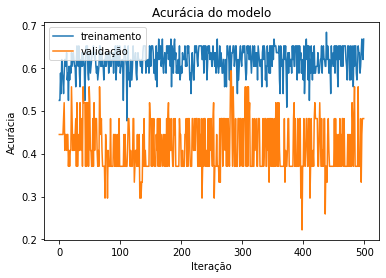

In [ ]:
history = model.fit(x_train, y_train, epochs=500, validation_data=(x_test, y_test), verbose=0)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Acurácia do modelo')
plt.ylabel('Acurácia')
plt.xlabel('Iteração')
plt.legend(['treinamento', 'validação'], loc='upper left')
plt.show()

In [ ]:
score = model.evaluate(x_test, y_test, verbose=2)

1/1 - 0s - loss: 0.4153 - accuracy: 0.4815
